# Proyecto 1: Resolución de la Ecuación de Navier Stokes

**Fundamentos de Dinámica de Fluidos Computacional**<br>
**Profesor Christopher Cooper**<br>
**6 de Noviembre de 2017**

Valentina Oyarzún _201292003-5_<br>
Joaquín Echaíz _201223520-0_


***

# Contenidos

1. [Introducción: Flujo en un Cambio de Sección](#one)
2. [Desarrollo](#two) <br>
    2.1. [Velocidad Inicial en $t=0$, y Condiciones de Borde](#two1) <br>
    2.2. [Discretización de la Ecuación Convección-Difusión Bidimensional](#two2) <br>
    2.3. [Discretización de la Ecuación Elíptica](#two3)<br>
      2.3.a. [Determinando la matriz F](#two3a)<br>
      2.3.b. [Solución de la ecuación elíptica para determinar Presión Interior](#two3b)<br>
      2.3.c. [Determinando la Presión Completa dentro del Volumen de Control](#two3c)<br>
    2.4. [Predicción de la Velocidad Futura](#two4)
3. [Resultados](#three)
4. [Análisis y Conclusiones](#four)<br>
    4.1. [Descripción general del flujo para varios pasos de tiempo](#four1)<br>
    4.2. [Caída de presión generada por expansión repentina](#four2)<br>
    4.3. [Estudio del efecto de variar el número de Reynolds, a través de la velocidad máxima](#four3)<br>
    4.4. [Confiabilidad de los resultados](#four4)<br>
    4.5. [Estudio de la inestabilidad del algoritmo y variaciones de $\Delta t$ y $\Delta x$](#four5)
----

# 1. Introducción: Flujo en un Cambio de Sección <a class="anchor" id="one"></a>

Figura 1. Representación gráfica del problema
![image](https://i.imgur.com/MEDkpG2.png)

En este proyecto se modelará el flujo incompresible en el dominio $L=2m$ en donde entra flujo por el lado izquierdo con un perfil cuadrático <font color=red>**(corrección)**</font> $u = V_{max} \frac{4}{L} \left(\eta-\frac{\eta^2}{L}\right)$ donde la velocidad es máxima, $V_{max}=1 \rm{m/s}$, en $\eta = L/2$. La densidad del fluido es $\rho=1\rm{kg/m^3}$, su viscosidad cinematica $ν = 0,1\rm{m/s^2}$, y se puede considerar como incompresible. 

La malla utilizada es de $41$ x $41$ nodos y un paso de tiempo $\Delta t=0,001\rm{s}$.

**Definicion de variables del problema:**

In [1]:
import numpy
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.linalg import solve
from scipy import sparse
from scipy.sparse.linalg import spsolve

numpy.set_printoptions(precision=3)

%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

L    = 2 # m
Vmax = 1 # m/s

N = 41 # Sea nx = ny = N nodos

# paso
dt = 0.001
delta = L/(N-1) # dx = dy = delta

nu  = 0.1  # viscosidad cinemática
rho = 1    # densidad

# malla
x = numpy.linspace(0, L, N)
y = numpy.linspace(L, 0, N)

# 2. Desarrollo<a class="anchor" id="two"></a>

## 2.1. Velocidad Inicial en $t=0$ y Condiciones de Borde <a class="anchor" id="two1"></a>

Al inicio, la velocidad dentro del volumen de control es mayormente cero.<br>
Se define la función `bordes` para verificar el cumplimiento de las condiciones de contorno en todo momento.

1. Condiciones en las paredes:
\begin{align}
u&=0, v=0 \text{ en } (x=0, y\leq L/2) \text{ , } (x=L, y\leq L/2) \text{ y } (x, y=0)\\
\end{align}

2. Condiciones a la entrada del flujo:
\begin{align}
u&=V_{max} \frac{4}{L} \left(\eta-\frac{\eta^2}{L}\right), v=0 \text{ en } (x=0, y>L/2)\\
\end{align}
\begin{align}
\eta = y-\frac{L}{2}\\
\end{align}

3. Condiciones en la linea de simetria:
\begin{align}
\frac{\partial u}{\partial y} &= 0, v=0 \text{ en } (x, y=L)\\
\end{align}
Discretizando,
\begin{align}
\frac {u_{i,j} - u_{i-1,j}}{\Delta} &= 0, \text{ para } i = 0\\
\end{align}

4. Condiciones a la salida del flujo:
\begin{align}
\frac{\partial u}{\partial x} &= 0, \frac{\partial v}{\partial x}=0 \text{ en } (x=L, y>L/2)
\end{align}
Discretizando,
\begin{align}
\frac {u_{i,j} - u_{i,j-1}}{\Delta} &= 0, \text{ para } i \in i\_apertura, j = -1\\
\frac {u_{i,j} - v_{i,j-1}}{\Delta} &= 0, \text{ para } i \in i\_apertura, j = -1\\
\end{align}
En donde $i\_apertura$ es un numpy.array conteniendo todos los valores para $i$ en donde se encuentra la entrada y la salida del flujo: <br>
`i_apertura = numpy.where(y>L/2)` <br>
Similarmente $i\_paredes$ contiene todos los valores para $i$ en donde estan las paredes, <br>
`i_paredes = numpy.where(y<=L/2)`

In [2]:
# Construcción de velocidad u, v en tiempo cero.

def bordes(u,v,L,N):
    # Condiciones de pared
    i_paredes = numpy.where(y<=L/2) # Valor filas (i) para la altura de las paredes
    u[i_paredes, 0:N:N-1]=0 # u=0 para y<=L/2, x=0 y x=L
    v[i_paredes, 0:N:N-1]=0 # v=0 para y<=L/2, x=0 y x=L

    u[-1,:] = 0
    v[-1,:] = 0

    # Condiciones de la entrada
    i_apertura = numpy.where(y>L/2) # Valor filas (i) para ambas aperturas, entrada y salida
    eta = y[i_apertura[0]] - L/2.
    u[i_apertura, 0] = Vmax*(4/L)*(eta-(eta**2)/L)
    v[i_apertura, 0] = 0

    # Condiciones en la linea superior
    u[0,1:-1]=u[1,1:-1]
    v[0,1:-1] = 0

    # Condiciones en la salida
    u[i_apertura, -1] = u[i_apertura, -2]
    v[i_apertura, -1] = v[i_apertura, -2]
    
    return u, v

# u, v para t=0[s]
u_0 = numpy.zeros((N,N))
v_0 = numpy.zeros((N,N))
u_0, v_0 = bordes( u_0, v_0, L, N)

## 2.2 Discretización de la Ecuación Convección-Difusión Bidimensional. <a class="anchor" id="two2"></a>

Definición de velocidad "intermedia" **$V^* = \left(u^*,v^*\right)$**, componente $x$:

\begin{align}
\frac{u^* - u^n}{\Delta t}= - u^n \frac{\partial u^n}{\partial x} - v^n \frac{\partial u^n}{\partial y} + \nu \left( \frac{\partial^2 u^n}{\partial x^2} + \frac{\partial^2 u^n}{\partial y^2} \right)\\
\end{align}

Se discretiza la ecuación utilizando diferencias atrasadas para la primera derivada y centradas en la segunda, método de orden $ O \left( h^2 \right)$.

\begin{equation}
u_{i,j}^{*} = u_{i,j}^n - u_{i,j}^n \Delta t \left(\frac{u_{i,j}^n - u_{i,j-1}^n}{\Delta x} \right) - v_{i,j}^n \Delta t \left(\frac{u_{i,j}^n - u_{i-1,j}^n}{\Delta y} \right) + \nu \Delta t \left( \frac{u_{i,j-1}^n -2 u_{i,j}^n +u_{i,j+1}^n}{\Delta x^2} + \frac{u_{i-1,j}^n -2 u_{i,j}^n + u_{i+1,j}^n}{\Delta y^2} \right)
\end{equation}

Siendo la malla regular en ambos sentidos con $\Delta x=\Delta y = \Delta$, $\left(u^*, v^*\right)$ quedan:

\begin{equation}
u_{i,j}^{*} = u_{i,j}^n - u_{i,j}^n \frac{\Delta t}{\Delta} \left(u_{i,j}^n - u_{i,j-1}^n\right) - v_{i,j}^n \frac{\Delta t}{\Delta} \left( u_{i,j}^n - u_{i-1,j}^n \right) + \nu \frac{\Delta t}{\Delta^2} \left( -4 u_{i,j}^n + u_{i,j-1}^n + u_{i-1,j}^n + u_{i,j+1}^n + u_{i+1,j}^n\right)
\end{equation}

\begin{equation}
v_{i,j}^{*} = v_{i,j}^n - u_{i,j}^n \frac{\Delta t}{\Delta} \left(v_{i,j}^n - v_{i,j-1}^n\right) - v_{i,j}^n \frac{\Delta t}{\Delta} \left( v_{i,j}^n - v_{i-1,j}^n \right) + \nu \frac{\Delta t}{\Delta^2} \left(-4 v_{i,j}^n + v_{i,j-1}^n + v_{i-1,j}^n + v_{i,j+1}^n + v_{i+1,j}^n\right)
\end{equation}

In [3]:
def V_ast(u, v, delta, dt, nu):
    u_ast = u.copy()
    v_ast = v.copy()

    u_ast[1:-1,1:-1]=\
    u[1:-1,1:-1] - u[1:-1,1:-1]*dt/delta*(u[1:-1,1:-1]-u[1:-1,:-2]) - v[1:-1,1:-1]*dt/delta*(u[1:-1,1:-1]-u[:-2,1:-1])\
    + nu*dt/(delta**2)*(-4*u[1:-1,1:-1] + u[1:-1,:-2] + u[:-2,1:-1] + u[1:-1,2:] + u[2:,1:-1])

    v_ast[1:-1,1:-1]=\
    v[1:-1,1:-1] - u[1:-1,1:-1]*dt/delta*(v[1:-1,1:-1]-v[1:-1,:-2]) - v[1:-1,1:-1]*dt/delta*(v[1:-1,1:-1]-v[:-2,1:-1])\
    + nu*dt/(delta**2)*(-4*v[1:-1,1:-1] + v[1:-1,:-2] + v[:-2,1:-1] + v[1:-1,2:] + v[2:,1:-1])

    # Condiciones de borde de u*, v* son las mismas que para u, v
    u_ast, v_ast = bordes(u_ast, v_ast, L, N);
    return u_ast, v_ast

## 2.3. Discretización de la Ecuación Elíptica <a class="anchor" id="two3"></a>

La **presión al interior** del volumen de control se modela:

\begin{equation}
\frac{\partial^2 P^{n+1}}{\partial x^2} + \frac{\partial^2 P^{n+1}}{\partial y^2} = \frac{\rho}{\Delta t} \cdot div\left(V^*\right)
\end{equation}

Discretizando usando diferencias centradas:

\begin{equation}
P_{i,j+1} + P_{i+1,j} - 4P_{i,j} + P_{i,j-1} + P_{i-1,j} = f_{i,j} \cdot \Delta^2
\end{equation}

Finalmente, se modela el sistema de ecuaciones necesario:

\begin{equation}
\left[ A \right] \left[P\right] = \left[ F \right]. 
\end{equation}

Se recorre la malla de la siguiente forma: 
![image](https://i.imgur.com/y6yi1v2.png)

### 2.3.a. Determinando la Matriz $\left[F\right]$ <a class="anchor" id="two3a"></a>

La divergencia se utilizará para calcular la presión interna del volumen de control. Por lo tanto, solo se calculará la divergencia en los puntos internos y $div \left(V^*\right)$ será una matriz de $(N-1) \times (N-1)$
\begin{align}
div \left(V^*\right) = \frac{\partial u^*}{\partial x} + \frac{\partial v^*}{\partial y}\\
\end{align}

Discretizando por diferencias centradas:

\begin{align}
div \left(V^*\right) = \frac{1}{2 \Delta}  \left(u^*_{i,j+1}-u^*_{i,j-1} + v^*_{i+1,j}-v^*_{i-1,j}\right)\\
\end{align}

Luego, $\left[F\right]$ es un vector columna que depende de la divergencia de $V^*$:

\begin{align}
\left[F\right] = - \frac{\rho \cdot \Delta^2}{\Delta t} \cdot div \left(V^*\right)
\end{align}

In [4]:
# Divergencia de V* para puntos interiores

def matrizF(u_ast, v_ast):
    divV_ast = numpy.zeros((N-2,N-2))
    divV_ast = (1/(2*delta))*(u_ast[1:-1,2:] - u_ast[1:-1,:-2] + v_ast[2:, 1:-1] - v_ast[:-2, 1:-1])
    f = (rho/dt)*(divV_ast)
    F = f.reshape(f.size,1)*(-1)*delta**2
    return F

### 2.3.b. Generación de la matriz $\left[A\right]$ <a class="anchor" id="two3b"></a>

Primero, debemos conocer las condiciones de borde fuera de la matriz $\left[A\right]$. Estas fueron discretizadas utilizado metodos simples de diferencias adelantas y atrasadas.
![image](https://i.imgur.com/uvuLECa.png)

Con estas condiciones se pueden determinar los coeficientes a ingresar en la matriz $\left[A\right]$ para los cinco bordes y las cuatro esquinas dentro de la matriz.

**1. Borde derecho superior $(j=N-2, i \in i\_apertura)$**
\begin{align}
P_{i+1,N-2} - 4P_{i,N-2} + P_{i,N-2} + P_{i-1,N-2} = f_{i,N-2} \cdot \Delta^2
\end{align}
**2. Borde izquierdo $(j=1)$**
\begin{align}
P_{i,2} + P_{i+1,1} - 3P_{i,j} + P_{i-1,1} = f_{i,1} \cdot \Delta^2
\end{align}
**3. Borde derecho inferior $(j=N-2, i \in i\_paderes)$**
\begin{align}
P_{i+1,N-2} - 3P_{i,N-2} + P_{i,N-3} + P_{i-1,N-2} = f_{i,N-2} \cdot \Delta^2
\end{align}
**4. Borde inferior $(i=N-2)$**<br>
\begin{align}
P_{N-2,j+1} - 3P_{N-2,j} + P_{N-2,j-1} + P_{N-3,j} = f_{N-2,j} \cdot \Delta^2
\end{align}
**5. Borde superior $(i=1)$**
\begin{align}
P_{1,j+1} + P_{2,j} - 3P_{i,j} + P_{1,j-1} = f_{1,j} \cdot \Delta^2
\end{align}
**Esquina superior derecha $(i=1, j=N-2)$**
\begin{align}
P_{2,N-2} - 3P_{1,N-2} + P_{1,N-3} = f_{1,N-2} \cdot \Delta^2
\end{align}
**Esquina superior izquierda $(i=1, j=1)$**
\begin{align}
P_{1,2} + P_{2,1} - 2P_{1,1} = f_{1,1} \cdot \Delta^2
\end{align}
**Esquina inferior izquierda $(i=N-2, j=1)$**
\begin{align}
P_{N-2,2} - 2P_{N-2,1} + P_{N-3,1} = f_{N-2,1} \cdot \Delta^2
\end{align}
**Esquina inferior derecha $(i=N-2, j=N-2)$**
\begin{align}
- 2P_{N-2,N-2} + P_{N-2,N-3} + P_{N-3,N-2} = f_{N-2,N-2} \cdot \Delta^2
\end{align}

In [5]:
# Consideracion al construir matriz A:
# Distancia entre i, i+1 es = (N-2) elementos
# Distancia entre j, j+1 es = 1 elemento

def generateMatrix(N):
    A = numpy.zeros(((N-2)*(N-2),(N-2)*(N-2)))
    
    i_paredes = numpy.where(y<=L/2)[0]
    i_apertura = numpy.where(y>L/2)[0]
    
    row_number = 0 # Contador de fila
    for i in range(1,N-1):
        for j in range(1,N-1):
            
            # Esquinas
            if i==1 and j==N-2: # Top right corner
                A[row_number,row_number] = 3        # diagonal
                A[row_number,row_number-1] = -1     # j-1
                A[row_number,row_number+(N-2)] = -1 # i+1

            elif i==1 and j==1: # Top left corner 
                A[row_number,row_number] = 2        # diagonal
                A[row_number,row_number+1] = -1     # j+1
                A[row_number,row_number+(N-2)] = -1 # i+1
                
            elif i==N-2 and j==1: # Bottom left corner
                A[row_number,row_number] = 2         # diagonal
                A[row_number,row_number+1] = -1      # j+1
                A[row_number,row_number-(N-2)] = -1  # i-1
                
            elif i==N-2 and j==N-2: # Bottom right corner
                A[row_number,row_number] = 2          # diagonal
                A[row_number,row_number-1] = -1       # j-1
                A[row_number,row_number-(N-2)] = -1   # i-1
                
            # Bordes
            elif j==N-2 and i in i_apertura: # Salida (Borde derecho superior)
                A[row_number,row_number] = 4         # diagonal
                A[row_number,row_number-1] = -1      # j-1
                A[row_number,row_number+(N-2)] = -1  # i+1
                A[row_number,row_number-(N-2)] = -1  # i-1
                
            elif j==1: # Borde izquierdo
                A[row_number,row_number] = 3         # diagonal
                A[row_number,row_number+1] = -1      # j+1
                A[row_number,row_number+(N-2)] = -1  # i+1
                A[row_number,row_number-(N-2)] = -1  # i-1
            
            elif j==N-2 and i in i_paredes: # Borde derecho inferior
                A[row_number,row_number] = 3        # diagonal
                A[row_number,row_number-1] = -1     # j-1
                A[row_number,row_number+(N-2)] = -1 # i+1
                A[row_number,row_number-(N-2)] = -1 # i-1
                
            elif i==N-2: # Borde inferior (suelo)
                A[row_number,row_number] = 3        # diagonal
                A[row_number,row_number+1] = -1     # j+1
                A[row_number,row_number-1] = -1     # j-1
                A[row_number,row_number-(N-2)] = -1 # i-1
                
            elif i==1: # Borde Superior
                A[row_number,row_number] = 3         # diagonal
                A[row_number,row_number+1] = -1      # j+1
                A[row_number,row_number-1] = -1      # j-1
                A[row_number,row_number+(N-2)] = -1  # i+1
                
            # Interior
            else:
                A[row_number,row_number] = 4         # diagonal
                A[row_number,row_number+1] = -1      # j+1
                A[row_number,row_number-1] = -1      # j-1
                A[row_number,row_number+(N-2)] = -1  # i+1
                A[row_number,row_number-(N-2)] = -1  # i-1
                
            row_number += 1 # proxima fila
            
    A_sparse = sparse.csr_matrix(A)
    return A_sparse

A = generateMatrix(N)
# ¡No generar matriz A dentro del ciclo for!

### 2.3.c. Determinando la Presión Completa dentro del Volumen de Control <a class="anchor" id="two3c"></a>


Ahora para transformar `P_interno` en una matriz de dos dimensiones se utilizan las condiciones de borde dadas. Luego con estos valores, se puede determinar el gradiente de presion interno.

In [6]:
def PresionTotal(P_interior, N):

    P = numpy.zeros((N,N))
    
    P[1:-1,1:-1]=P_interior.reshape(N-2,N-2)
    i_paredes = numpy.where(y<=L/2)[0]
    i_apertura = numpy.where(y>L/2)[0]
    
    # Condicion borde 1
    P[i_apertura,N-1]=0
    # Condicion borde 2
    P[:,0]=P[:,1]
    # Condicion borde 3
    P[i_paredes,N-1]=P[i_paredes,N-2]
    # Condicion borde 4
    P[N-1,:]=P[N-2,:]
    # Condicion borde 5
    P[0,:]=P[1,:]
    
    return P

def gradiente(P,N):
    dPdx = numpy.zeros((N-2,N-2))
    dPdx = (1/(2*delta))*(P[1:-1,2:] - P[1:-1,:-2])
    
    dPdy = numpy.zeros((N-2,N-2))
    dPdy = (1/(2*delta))*(P[2:, 1:-1] - P[:-2, 1:-1])
    
    return dPdx, dPdy

## 2.4. Predicción de la Velocidad Futura <a class="anchor" id="two4"></a>

Utilizando el gradiente, y observando que el resultado de la ecuación elíptica nos dió $\left[-P\right]$, podemos calcular el siguiente valor de $V$ después de un tiempo $\Delta t$.

\begin{align}
u^{n+1} &= \frac{\Delta t}{\rho} \frac{\partial P^{n+1}}{\partial x} + u^*
\end{align}

\begin{align}
v^{n+1} &= \frac{\Delta t}{\rho} \frac{\partial P^{n+1}}{\partial y} + v^*
\end{align}

In [7]:
def V_nuevo(dPdx, dPdy, u_ast, v_ast, N):
    u_nuevo = numpy.zeros((N,N))
    u_nuevo[1:-1, 1:-1] = -(dt/rho)*dPdx + u_ast[1:-1,1:-1]
    
    v_nuevo = numpy.zeros((N,N))
    v_nuevo[1:-1, 1:-1] = -(dt/rho)*dPdy + v_ast[1:-1,1:-1]
    
    u_nuevo, v_nuevo = bordes(u_nuevo,v_nuevo,L,N)
    return u_nuevo, v_nuevo

# 3. Resultados <a class="anchor" id="three"></a>

Para cada paso de tiempo se debe usar la velocidad anterior para calcular:
1. Velocidad Intermedia, $V^*$.
2. Divergencia de $V^*$, y la matriz $\left[F\right]$.
3. Resolver la ecuación elíptica para obtener la presión interna.
4. Usar las condiciones de borde dadas para obtener la presión dentro de todo el volumen de control.
5. Calcular la gradiente de presión y luego el valor de $V^{n+1}$, el nuevo valor de la velocidad.

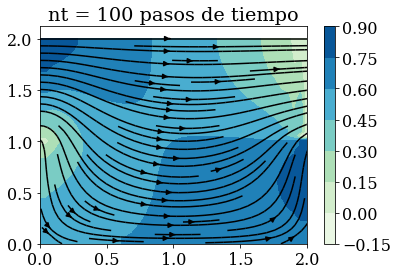

In [8]:
def solucion(nt): # nt = pasos de tiempo
    u = u_0
    v = v_0
    for i in range(nt):
        u_ast, v_ast = V_ast(u, v, delta, dt, nu)                   # Cálculo de V* usando V
        F = matrizF(u_ast, v_ast)                                   # Cálculo de matriz F para resolver la ecuacion eliptica
        P_interior = spsolve(A, F)                                  # Cálculo de Presión interior despues de un tiempo dt
        P = PresionTotal(P_interior, N)                             # Reordenando Presión y enforzando condiciones de borde
        dPdx, dPdy = gradiente(P, N)                                # Gradiente de Presión (puntos interiores)
        u_nuevo, v_nuevo = V_nuevo(dPdx, dPdy, u_ast, v_ast, N)     # Calculo de V^{n+1} en un paso de tiempo dt
        u = u_nuevo
        v = v_nuevo
    return u, v, P
      
    
# Para 100 pasos de tiempo,
u, v, P = solucion(100)
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title('nt = 100 pasos de tiempo')
P100=P

# 4. Análisis y Conclusiones <a class="anchor" id="four"></a> <br>
## 4.1. Haga una descripción general del flujo para varios pasos de tiempo (100,1000, 5000, 10000, etc.) pasos de tiempo ¿Llega a un estado estacionario? <a class="anchor" id="four1"></a>

A continuación se mostrarán sistemas resueltos para el flujo en distintos pasos de tiempo $nt$ con su descripción general al pie.

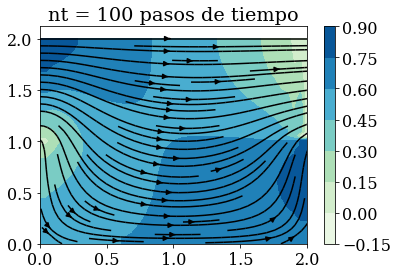

In [9]:
u, v, P = solucion(100)
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title('nt = 100 pasos de tiempo')

**100 pasos de tiempo $0.1 [s]$: **Luego de la expansión repentina de la sección, el flujo se desplaza llenando la cavidad, y mueve a su paso gran parte del fluido dentro de ella para luego abandonar la sección por la abertura de salida.

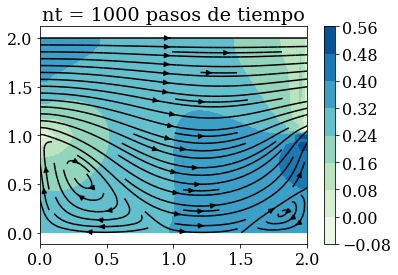

In [10]:
u, v, P = solucion(1000)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title('nt = 1000 pasos de tiempo')

**1.000 pasos de tiempo $1 [s]$: ** En las esquinas de la sección cuadrada comienzan a aparecer pequeños puntos de recirculación,  lineas que forman curvas cerradas. Estas indican que parte del fluido permanece en la sección y tiene comportamiento turbulento.

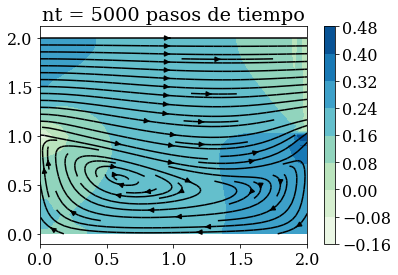

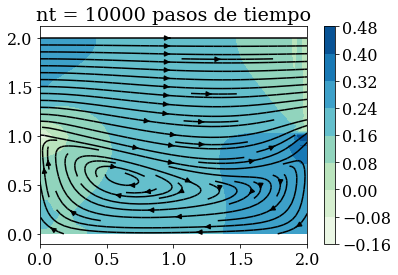

In [11]:
u, v, P = solucion(5000)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title('nt = 5000 pasos de tiempo')

u, v, P = solucion(10000)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title('nt = 10000 pasos de tiempo')

**5.000 pasos de tiempo $5 [s]$ y 10.000 pasos de tiempo $10 [s]$: **Los puntos de recirculación vistos anteriormente crecen y pasan a convertir la parte inferior de la sección en una gran zona de recirculación. El fluido que entra transita hacia la salida de manera mas recta, o de forma laminar.

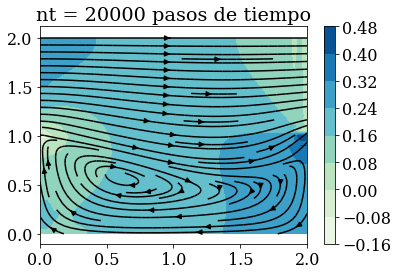

In [12]:
u, v, P = solucion(20000)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title('nt = 20000 pasos de tiempo')

**20.000 pasos de tiempo $20 [s]$: **Se pueden observar las mismas caracteristicas que lo sucedido tras 10.000 pasos de tiempo, por lo que se estima que en algún momento entre los 5 y 10 segundos el sistema comienza a comportarse de forma estacionaria. El flujo que entra pasa casi sin fluctuaciones hacia la salida.<br>


## 4.2. Caída de presión generada por expansión repentina (Estimación) <a class="anchor" id="four2"></a>

In [13]:
maxP=numpy.amax(P100)
dondemax=numpy.where(P>=numpy.amax(P100))

minP=numpy.amin(P100)
dondemin=numpy.where(P<=numpy.amin(P100))

print("La máxima presión se encuentra en: "+str(dondemax)+"Esta es de: "+str(maxP))
print("La mínima presión se encuentra en: "+str(dondemin)+"Esta es de: "+str(minP))
print("La caida de presión generada es de: "+str(maxP-minP)+"[Pa]")

La máxima presión se encuentra en: (array([], dtype=int64), array([], dtype=int64))Esta es de: 0.853816304155
La mínima presión se encuentra en: (array([20, 20, 21, 21], dtype=int64), array([0, 1, 0, 1], dtype=int64))Esta es de: -0.0145662320036
La caida de presión generada es de: 0.868382536159[Pa]


En el menor de los intervalos de tiempo estudiados, el más repentino de $0.1 [s]$, tiene una presión máxima de $Pmax=0.85 [Pa]$ y una presión mínima de $Pmin=-0.0145 [Pa]$. Por lo que la caída de presión más grande en este sistema es $\Delta P=0.8683[Pa]$.<br>

Un aspecto relevante de esta caída de presión es el lugar en dónde ocurre, ya que la presión máxima y mínima se encuentran relativamente cerca al interior del sistema. Más específicamente en los índices $[22,39]$ y $[19,39]$ (leídos como $[i,j]$ o $[y,x]$ según el sistema de referencia anteriormente indiado), estos puntos representan los sectores más próximos a la esquina de salida del fluido del cambio de sección. La aceleración del flujo al salir genera estas grandes caídas de presión.<br>

Todo lo anterior también se puede observar en el esquema generado para los primeros 100 pasos de tiempo, a la salida del flujo se encuentran zonas de color que muestran tanto la topología de la presión más alta junto a la que representa la más baja. Esta condición que se mantiene para el resto de los pasos de tiempo, pero que va atenuando en magnitud.
## 4.3. Estudio del efecto de variar el número de Reynolds, a través de la velocidad $V_{max}$<a class="anchor" id="four3"></a>
Para este estudio se cambiará la velocidad $V_{max}$ a magnitudes menores y mayores que la establecida inicialmente de $1 [m/s]$<br>

En una primera etapa se analizará lo que sucede en $1[s]$con velocidades máximas de de $1[m/s]$, $10[m/s]$ y $0.01[m/s]$

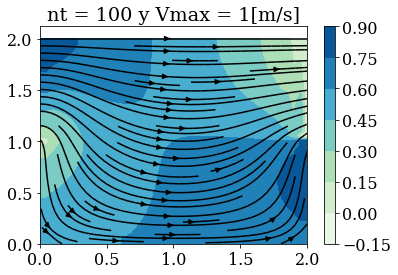

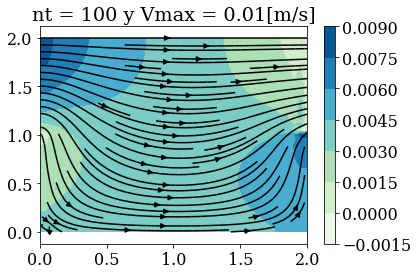

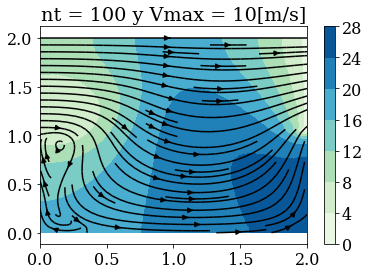

In [14]:
nt=100
Vmax = 1
u, v, P = solucion(nt)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title("nt = "+str(nt)+" y Vmax = "+str(Vmax)+"[m/s]")

Vmax = 0.01
u, v, P = solucion(nt)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title("nt = "+str(nt)+" y Vmax = "+str(Vmax)+"[m/s]")

Vmax = 10
u, v, P = solucion(nt)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title("nt = "+str(nt)+" y Vmax = "+str(Vmax)+"[m/s]")

Se observa que a mayor velocidad el sistema adopta más rápidamente la forma estacionaria que se analizó en el punto anterior, por lo tanto **el número de Reynolds está relacionado con a velocidad que se desarrolla el sistema.**<br>

Otro ejemplo es la propuesta de una segunda etapa en la cual se analizarán las mismas velocidades pero esta vez en $10[s]$

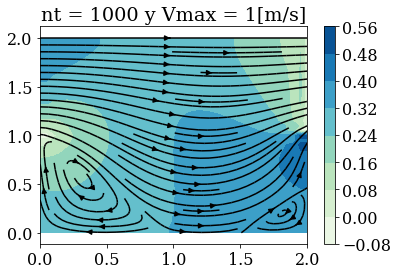

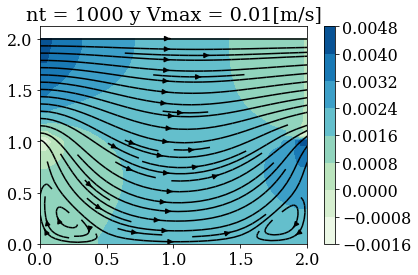

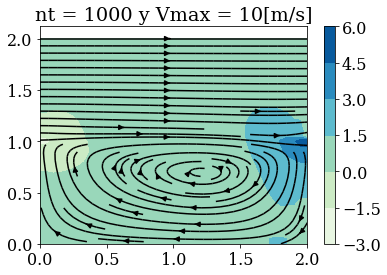

In [15]:
nt=1000
Vmax = 1
u, v, P = solucion(nt)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title("nt = "+str(nt)+" y Vmax = "+str(Vmax)+"[m/s]")

Vmax = 0.01
u, v, P = solucion(nt)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title("nt = "+str(nt)+" y Vmax = "+str(Vmax)+"[m/s]")

Vmax = 10
u, v, P = solucion(nt)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title("nt = "+str(nt)+" y Vmax = "+str(Vmax)+"[m/s]")

Nuevamente se observa que las velocidades menores a la original muestran un desarrollo del sistema menor con respecto al régimen estacionario, mientras que las velocidades superiores a la  original se desarrollan y logran el régimen estacionario más rápidamente.

## 4.4. Confiabilidad de los resultados<a class="anchor" id="four4"></a>

Si bien los resultados entregados en los esquemas nos parecen naturales y con alto sentido físico, es necesario tener siempre en consideración que, a pesar de haber trabajado con métodos de segundo orden para la discretización del espacio en el cuerpo del sistema, se enforzaron condiciones de borde que utilizan métodos de primer orden para los límites del volumen de control.

Lo anterior quiere decir que se incurre en un error considerable al utilizar este tipo de algoritmos y que depende de la aplicación y confiabilidad que se necesite para discernir si servirá o no como modelo.

Para aumentar la confiabilidad del algoritmo es recomendable utilizar otro tipo de discretización para las condiciones de borde, con la finalidad de tener un error menor al establecerlas. Un ejemplo de esto es utilizar el método de Neumann de alto orden o puntos fantasmas.

Otra forma de aumentar la confiabilidad del sistema, al costo de aumentar el tiempo de cálculo, es utilizár un método implícito que reduzca el error tanto en la discretización temporal como en la espacial. Se podrian utilizar los métodos de Crank Nicolson o del trapecio para cada punto de la malla.

## 4.5. Inestabilidad el algorítmo y variaciones de $\Delta t$ y $\Delta x$ <a class="anchor" id="four5"></a>

Al disminuir $N$ y por tanto aumentar $\Delta x$ el sistema sigue comportandose bien aunque varias de sus zonas se simplifican bastante. Incluso con 11 nodos o menos se continúa resolviendo. (_Tanteando se concluye que con más de 3 el código continuaba funcioando_).

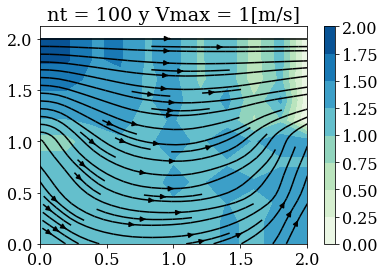

In [16]:
#Probando con 11 nodos dx=dy=0.1
N = 11 
dt = 0.001
delta = L/(N-1)
nt=100
Vmax = 1
x = numpy.linspace(0, L, N)
y = numpy.linspace(L, 0, N)
u_0 = numpy.zeros((N,N))
v_0 = numpy.zeros((N,N))
u_0, v_0 = bordes( u_0, v_0, L, N)
A = generateMatrix(N)

u, v, P = solucion(nt)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title("nt = "+str(nt)+" y Vmax = "+str(Vmax)+"[m/s]")

**11 nodos y $dt=0.001$: **Pese haber disminuido la cantidad de puntos que representan al fluido el sistema sigue funcioando.

Si en caso contrario se aumenta $N$ y por tanto se disminiye $\Delta x$ se llega a un punto en donde el sistema deja de tener sentido (explota), por lo que se infire una inestabilidad a partir de ese punto.

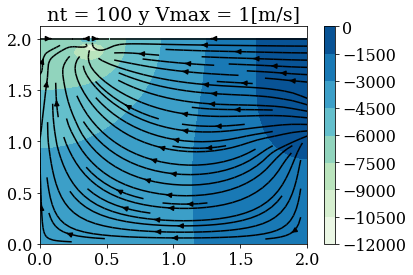

In [17]:
#Probando con 104 nodos dx=dy=1/104
N = 104
dt = 0.001
delta = L/(N-1)
nt=100
Vmax = 1
x = numpy.linspace(0, L, N)
y = numpy.linspace(L, 0, N)
u_0 = numpy.zeros((N,N))
v_0 = numpy.zeros((N,N))
u_0, v_0 = bordes( u_0, v_0, L, N)
A = generateMatrix(N)

u, v, P = solucion(nt)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title("nt = "+str(nt)+" y Vmax = "+str(Vmax)+"[m/s]")

**104 nodos y $dt=0.001$: **La información que originalmente entregaba el sistema se ha perdido al disminuir la magnitud del diferencial.

Para el caso de $\Delta t$ la inestabilidad ocurre de forma distinta. Al aumentar la magnitud de esta diferencia temporal ligeramente el algoritmo deja de funcionar. Se probó con valores cercanos al origina $\Delta t=0.001[s]$ y para $\Delta t=0.007[s]$ el código ya presentó inestabilidad.

In [18]:
N = 41
dt = 0.007
delta = L/(N-1)
nt=100
Vmax = 1
x = numpy.linspace(0, L, N)
y = numpy.linspace(L, 0, N)
u_0 = numpy.zeros((N,N))
v_0 = numpy.zeros((N,N))
u_0, v_0 = bordes( u_0, v_0, L, N)
A = generateMatrix(N)

u, v, P = solucion(nt)

C:\Users\Vale\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
C:\Users\Vale\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
C:\Users\Vale\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
C:\Users\Vale\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
C:\Users\Vale\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in add
  """


**41 nodos y $dt=0.007[s]$: **Se espera ver un error que indica la inestabilidad del sistema para esta condicion de $dt$.

Al disminuir la magnitud de $\Delta t$ el flujo sigue comportandose de la manera esperada. Sin mayores alteraciones tras reducir incluso más alla de tres ordenes de magnitud su valor original.

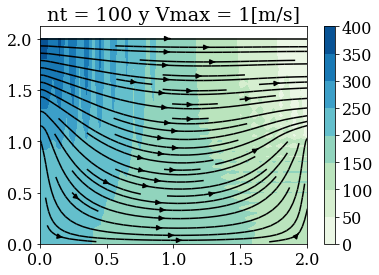

In [19]:
#Probando con dt = 0.000001 [s]
N = 41
dt = 0.000001
delta = L/(N-1)
nt=100
Vmax = 1
x = numpy.linspace(0, L, N)
y = numpy.linspace(L, 0, N)
u_0 = numpy.zeros((N,N))
v_0 = numpy.zeros((N,N))
u_0, v_0 = bordes( u_0, v_0, L, N)
A = generateMatrix(N)

u, v, P = solucion(nt)
plt.figure()
Paso_100 = plt.contourf(x, y, P, cmap=cm.GnBu)
plt.colorbar(Paso_100)
plt.streamplot(x, y, u, -v, color=(0,0,0,1))
plt.title("nt = "+str(nt)+" y Vmax = "+str(Vmax)+"[m/s]")

La inestabilidad presentada en las variaciones realizadas en este punto tienen su origen en la naturaleza de la discretización que emplea estos diferenciales.

La discretización temporal involucraba una derivada de primer orden y para realizarla fue necesario utilizar un método de primer orden: diferencias finitas adelantadas. La huella de este método se traduce en un error del tipo convectivo, es decir, de orden impar (en esta caso de primer orden) y que dispersa la información o señal.

La discretizacion espacial involucraba una doble derivada y para realizarla fue necesario utilizar un metodo de segundo orden, que es la combinación de diferencias finitas adelantadas y atrazadas. El rastro que deja este método se traduce en un error del tipo difusivo, es decir, de orden par (en este caso de segundo orden) y que atenua las señales o información con que se trabaja.